# Hoek-Brown 

https://en.wikipedia.org/wiki/Hoek%E2%80%93Brown_failure_criterion

The Hoel-Brown failure criterion is an empirical stress surface that is used in rock mechanics to predict the failure of rock.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_excel('original.xlsx', sheet_name='ROCDATA')
n=df.count()[0]

In [3]:
# Creating dataframes according to Test type and principal stresses

x_ucs=df[df['Test Type']=='UCS']['Sig3 (MPa)']
y_ucs=df[df['Test Type']=='UCS']['Sig1 (MPa)']
x_tcs=df[df['Test Type']=='TCS']['Sig3 (MPa)']
y_tcs=df[df['Test Type']=='TCS']['Sig1 (MPa)']
x_bts=df[df['Test Type']=='BCS']['Sig3 (MPa)']
y_bts=df[df['Test Type']=='BCS']['Sig1 (MPa)']

In [4]:
#Drawing mi and sigma sub ci

def bs_pairs_reg(x, y, size=1):
    """Perform pairs bootstrap for cuadratic regression"""
    # Converting df to arrays
    x1=np.array(x)
    y1=np.array(y)
    
    #Set up array of indices to sample from: inds
    inds = np.arange(len(x1))
    
    #Initialize replicates: bs_mi, bs_sci
    bs_mi = np.empty(size)
    bs_sci = np.empty(size)
    
    #Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x1[bs_inds], y1[bs_inds]
        
        a=np.sum(np.square(x1-y1))/len(x1)
        b=np.sum(x1*np.square(x1-y1))-np.sum(x1)*a
        c=np.sum(np.square(x1))-(np.sum(x1)**2)/len(x1)
        d=np.sum(x1)/len(x1)
        
        bs_sci[i]=(a-(b/c)*d)**0.5
        
        bs_mi[i]=(b/c)/bs_sci[i]
        
    return np.mean(bs_mi), np.mean(bs_sci)


In [5]:
mi, sigma_ci=bs_pairs_reg(x_tcs, y_tcs, 10000)
mi, sigma_ci

(8.910602833139468, 75.65341443557074)

In [6]:
#Creating (sigmaci) fit column according to the HB non-linear regression

df['sigma1_fit']=df['Sig3 (MPa)']+sigma_ci*(mi*df['Sig3 (MPa)']/sigma_ci+1)**0.5
df['sigma1_fit'].fillna(0, inplace=True)

In [7]:
#RSS and SE

from scipy import stats
t=stats.t.ppf(1-0.025, n-2)

In [8]:
sigma3=df['Sig3 (MPa)'].to_numpy()
sigma1=df['Sig1 (MPa)'].to_numpy()
sigma1_fit=df['sigma1_fit'].to_numpy()

#res: residual, norm_res: normalized residual
res=np.zeros(len(df.index), dtype='float')
norm_res=np.zeros(len(df.index), dtype='float')

for i in range(0, len(df.index)):
    if sigma3[i]<0 and sigma1[i]<5*np.absolute(sigma3[i]):
        res[i]=sigma3[i]-sigma1_fit[i]
        norm_res[i]=res[i]/sigma3[i]
    elif sigma3[i]<0 and sigma1[i]>5*np.absolute(sigma3[i]):
        res[i]=sigma1[i]-sigma1_fit[i]
        norm_res[i]=res[i]/sigma1_fit[i]
    elif sigma3[i]>=0:
        res[i]=sigma1[i]-sigma1_fit[i]
        norm_res[i]=res[i]/sigma1_fit[i]

In [9]:
#rss: residual sum of squares

rss=np.sum(np.square(res))

#se: standard error
#se=(rss/(n-2))^0.5
se=np.sqrt(rss/(n-2))  #se=20.212118936322643

# Prediction Interval

In [10]:
pi_low=np.zeros(len(df.index), dtype='float')
pi_upp=np.zeros(len(df.index), dtype='float')

#rs: regression squares
mu_sigma3=np.full(n,sigma3.mean())
rs=(sigma3-mu_sigma3)**2
k=np.sqrt(1+1/n+rs/rs.sum())

for i in range(0, len(df.index)):
    if sigma3[i]<0 and sigma1[i]<5*np.absolute(sigma3[i]):
        pi_low[i]=sigma3[i]-t*se*k[i]
        pi_upp[i]=sigma3[i]+t*se*k[i]
    else:
        pi_low[i]=sigma1_fit[i]-t*se*k[i]
        pi_upp[i]=sigma1_fit[i]+t*se*k[i]
    
                                              

In [11]:
df['low_pi']=pd.DataFrame(pi_low)
df['upp_pi']=pd.DataFrame(pi_upp)

# Hoek-Brown Nonlinearr repression plot

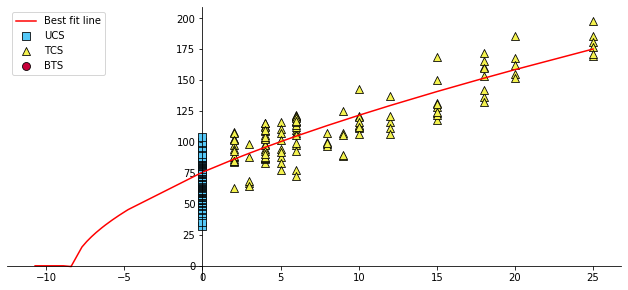

In [12]:
fig=plt.figure(figsize=(11,5))
plt.scatter(x_ucs, y_ucs, c='#55c8F7', marker='s', linewidths=.8, edgecolors='black', s=8**2, label='UCS')
plt.scatter(x_tcs, y_tcs, c='#F4F24E', marker='^', linewidths=.8, edgecolors='black', s=8**2, label='TCS')
plt.scatter(x_bts, y_bts, c='#c70039', marker='o', linewidths=.8, edgecolors='black', s=8**2, label='BTS')

#df2=df.sort_values(by='Sig3 (MPa)')
df2=df.sort_values('Sig3 (MPa)')
plt.plot(df2['Sig3 (MPa)'], df2['sigma1_fit'], 'r-', label='Best fit line')

ax = plt.gca() #gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))

#ax.set_xlabel(r'$\sigma_{3}(MPa)$)
#ax.set_ylabel(r "$\sigma_{1} (MPa)$")
plt.legend()
plt.show()

## Hoek-Brown Prediction Intervals plot

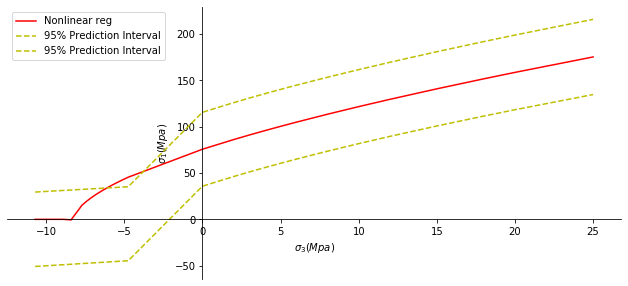

In [14]:
fig2=plt.figure(figsize=(11,5))

plt.plot(df2['Sig3 (MPa)'], df2['sigma1_fit'], 'r-', label='Nonlinear reg')
plt.plot(df2['Sig3 (MPa)'], df2['low_pi'], 'y--', label='95% Prediction Interval')
plt.plot(df2['Sig3 (MPa)'], df2['upp_pi'], 'y--', label='95% Prediction Interval')

ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))

ax.set_xlabel(r"$\sigma_{3} (Mpa)$")
ax.set_ylabel(r"$\sigma_{1} (Mpa)$")
plt.legend()
plt.show()


## Exporting df to excel

In [ ]:
#df.to_excel('HoekBrown_bestfit.xlsx')